# Exp 4: Train CEFR models
This experiments aims as using EFCAMDAT to train CEFR-aligned language models.

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['CACHE_DIR'] = os.environ['FAST_CACHE_DIR'].replace("%SLURM_JOB_ID%", os.getenv('SLURM_JOB_ID')) # speed up model loading

import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm
import json
import re
import xml.etree.ElementTree as ET
import datasets
from transformers import TrainingArguments, LogitsProcessor
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from peft import LoraConfig, PeftModel
from collections import Counter
import nltk
nltk.download("punkt", download_dir=os.getenv('CACHE_DIR'))
nltk.data.path.insert(0, os.getenv('CACHE_DIR'))
from nltk.tokenize import sent_tokenize
from rouge_score import rouge_scorer

import sys
sys.path.append(f'../source')
import models
import helpers
import data

import importlib
#importlib.reload(helpers)

# CONFIGURATION
DATA_PATH = "../data/"
efcamdat_path = f"{DATA_PATH}EFCAMDAT_Database.xml"
preprossed_dataset_file = f"{DATA_PATH}CEFR_texts.jsonl"
dialogs_file = f"{DATA_PATH}CEFR_dialogs.json"
preprossed_dialog_file = f"{DATA_PATH}CEFR_dialogs.jsonl"
checkpoint_dir = '/cluster/scratch/dglandorf/models/'


2024-06-03 09:55:31.314537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package punkt to
[nltk_data]     /scratch/tmp.61360934.dglandorf...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /scratch/tmp.61360934.dglandorf...
[nltk_data]   Package punkt is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

[nltk_data] Downloading package punkt to
[nltk_data]     /scratch/tmp.61360934.dglandorf...
[nltk_data]   Package punkt is already up-to-date!


## Data Pre-Processing

Sanitize the EF-CAMDAT to be able to read it in without errors: Fix an error due to the <br> tag

In [ ]:
with open(efcamdat_path, 'r', encoding='utf-8') as file:
    file_content = file.read()
updated_content = file_content.replace('<br>', '<br />')
with open(efcamdat_path, 'w', encoding='utf-8') as file:
    file.write(updated_content)

lines_to_remove = list(range(5080477, 5080486))
with open(efcamdat_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()
for line in lines[lines_to_remove]:
    print(line)
#del lines[lines_to_remove] # remove them # CAUTION: do not execute this twice, it will remove other lines then
with open(efcamdat_path, 'w', encoding='utf-8') as file:
    file.writelines(lines)

Let's remove the corrected text from the xml file

In [145]:
def extract_uncorrected_text(element):
    """Extracts the uncorrected text from the <text> element, ignoring corrections."""
    parts = []

    if element.text:
        parts.append(element.text)
        
    for sub_elem in element:
        if sub_elem.tag == 'change':
            selection = sub_elem.find('selection')
            if selection is not None and selection.text:
                parts.append(selection.text)
            if sub_elem.tail:
                parts.append(sub_elem.tail)
        else:
            if sub_elem.text:
                parts.append(sub_elem.text)
            if sub_elem.tail:
                parts.append(sub_elem.tail)
            
    return ''.join(parts)

In [176]:
data = []
context = ET.iterparse(efcamdat_path, events=('end',))

for event, elem in tqdm(context, total=36000000):
    if elem.tag == 'writing':
        text = extract_uncorrected_text(elem.find('text'))
        data.append({
            "id": elem.get('id'),
            "text": text.strip(),
            "level": int(elem.get('level'))
        })

efcamdat = pd.DataFrame(data)

  0%|          | 0/36000000 [00:00<?, ?it/s]

Map the level to CEFR

In [178]:
grade_to_cefr = {
    range(1, 4): 'A1',
    range(4, 7): 'A2',
    range(7, 10): 'B1',
    range(10, 13): 'B2',
    range(13, 16): 'C1',
    range(16, 17): 'C2',
}

def map_grade_to_cefr(grade):
    for grade_range, cefr in grade_to_cefr.items():
        if grade in grade_range:
            return cefr
    return None
efcamdat['CEFR'] = efcamdat['level'].apply(map_grade_to_cefr)

efcamdat['CEFR'].value_counts(dropna=False)

A1    625985
A2    307995
B1    168361
B2     61329
C1     14698
C2      1940
Name: CEFR, dtype: int64

Count words per text (simply count spaces)

In [179]:
def map_text_to_num_words(text):
    return len(text.split())
    
efcamdat['num_words'] = efcamdat.text.apply(map_text_to_num_words)

In [180]:
efcamdat.groupby('CEFR').agg({"num_words": "mean"})

,num_words
CEFR,
A1,36.453861
A2,65.246595
B1,94.152660
B2,132.331393
C1,165.214315
C2,169.732990


In [181]:
efcamdat['num_words'].sum()

69640185

Convert into datasets library format

In [ ]:
if not os.path.exists(preprossed_dataset_file):
    with open(preprossed_dataset_file, 'w') as f:
        for idx, row in tqdm(efcamdat.iterrows(), total=len(efcamdat)):
            item = {
                "CEFR": row['CEFR'],
                "text": str(row['text']),
            }
            f.write(json.dumps(item) + '\n')

## Preprocess texts to dialogs

In [4]:
model, tokenizer = models.load_generator("meta-llama/Meta-Llama-3-8B-Instruct")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
# Generate dialogs with these phrases
dialogs = []
dataset = datasets.load_dataset('json', data_files=preprossed_dataset_file, split='train')
dataset = dataset.shuffle()
for item in dataset:
    print(item)
    chat_messages = tokenizer.apply_chat_template([{"role": "user", "content": f"Write a dialog using exact phrases including mistakes from this text: {item['text']}. Do not explain mistakes."}], tokenize=False, add_generation_prompt=True)
    response = models.generate(model, tokenizer, [chat_messages], max_new_tokens=256)
    dialog = [utterance.strip() for utterance in response.split("\n")]
    
    try:
        cleaned = [re.search(r'.*: (.*)', turn).group(1) for turn in dialog[1:-1] if len(turn)>3]
        print(cleaned)
        if len(cleaned):
            dialogs.append({"CEFR": item['CEFR'],
                            "writing": item['text'],
                            "dialog": cleaned})
        else:
            print(response)
    except:
        print(response)

Generating train split: 0 examples [00:00, ? examples/s]

{'CEFR': 'B2', 'text': 'This summer one friend of mine from the US visited Russia. One day we went out with our other friends. We had changed the bar and drink more and more vodka. We want to show American how we can drink. We drank as much as we can. In next bar we decided to stop drink finally. It was about 5 a.m. there. We left the bar and went outside the street. Just imagine, Saint-Petersburg, city center, old beutiful buildings. Then one our friend decided to piss on the street. He had just turned back and made his business. What the awkward situation, i was so embarassed.'}


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.89s/it]


['"This summer one friend of mine from the US visited Russia. One day we went out with our other friends. We had changed the bar and drink more and more vodka. We want to show American how we can drink. We drank as much as we can."', '"Yeah, I remember that night. We were really getting wild, weren\'t we?"', '"Yeah, we were. In next bar we decided to stop drink finally. It was about 5 a.m. there."', '"And then we left the bar and went outside the street. Just imagine, Saint-Petersburg, city center, old beutiful buildings."', '"Then one our friend decided to piss on the street. He had just turned back and made his business."', '"What the awkward situation, i was so embarassed..."', '"I know, right? I was mortified. I didn\'t know what to do."']
{'CEFR': 'B2', 'text': "It's really a pity to hear that you gonna leave this company due to your claustrophobia.You know what ? You do have a good job and great ability,it is not worth to let it destroy your life and opportunity. I don't know if 

Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.34s/it]


["It's really a pity to hear that you gonna leave this company due to your claustrophobia.", "Yeah, I'm really struggling with it. You know what? You do have a good job and great ability, it is not worth to let it destroy your life and opportunity.", "Exactly! I don't know if you ever go to see the doctor, if you don't, I think it is a good way to get some suggestion about how to control even better to resolve your problem.", "Yeah, I've been thinking about it. Actually, there is a training can let you improve your mind to a more positive and peaceful, it's call Cognitive Behavioral Therapy (CBT).", "Ah, I've heard of that! Many people have this problem just like you but have been better through this training, it might be help for you too.", "Yeah, I'm considering it. Anyway, you know I'll always be on your side."]
{'CEFR': 'A1', 'text': 'Dear Ms Thomas,There are thirteen computers and sixteen keyboards in the office. Also, there are thirty pens and fifteen pencils. There are twelve de

Generate:   0%|                                                                                                      | 0/1 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
#dialogs.to_json(dialogs_file)

Read generated dialogs

In [16]:
dialogs_df = pd.read_json(dialogs_file)
len(dialogs_df)

6591

Only use turns as target that are adopted from the original writing -> Rouge-L recall

In [ ]:
scorer = rouge_scorer.RougeScorer(['rougeL'])
snippets = []
for idx, dialog in tqdm(dialogs_df.iterrows(), total=len(dialogs_df)):
    scores = [scorer.score(dialog['dialog'][i], dialog['writing'])['rougeL'][1] for i in range(1, len(dialog['dialog']))]
    if not len(scores): continue
    threshold = sorted(scores, reverse=True)[max(0, len(scores)//2-1)]
    for i in range(1, len(dialog['dialog'])):
        if scores[i-1]<threshold: continue
        snippet = {"writing": dialog['writing'],
                   "CEFR": dialog['CEFR'],
                   'context': dialog['dialog'][:i],
                   'response': dialog['dialog'][i]}
        snippets.append(snippet)

if not os.path.exists(preprossed_dialog_file) or True:
    with open(preprossed_dialog_file, 'w') as f:
        for snippet in tqdm(snippets):
            f.write(json.dumps(snippet) + '\n')

len(snippets)

# Fine-tune models to write on a certain CEFR level

## Fine-tune on dialogs

In [14]:
description = {
    "C2": "Has a good command of idiomatic expressions and colloquialisms with awareness of connotative levels of meaning. Can convey finer shades of meaning precisely by using, with reasonable accuracy, a wide range of modification devices. Can backtrack and restructure around a difficulty so smoothly that the interlocutor is hardly aware of it.",
    "C1": "Can express themselves fluently and spontaneously, almost effortlessly. Has a good command of a broad lexical repertoire allowing gaps to be readily overcome with circumlocutions. There is little obvious searching for expressions or avoidance strategies; only a conceptually difficult subject can hinder a natural, smooth flow of language.",
    "B2": "Can interact with a degree of fluency and spontaneity that makes regular interaction, and sustained relationships with users of the target language, quite possible without imposing strain on either party. Can highlight the personal significance of events and experiences, and account for and sustain views clearly by providing relevant explanations and arguments.",
    "B1": "Can communicate with some confidence on familiar routine and non-routine matters related to their interests and professional field. Can exchange, check and confirm information, deal with less routine situations and explain why something is a problem. Can express thoughts on more abstract, cultural topics such as films, books, music, etc.",
    "A2": "Can interact with reasonable ease in structured situations and short conversations, provided the other person helps if necessary. Can manage simple, routine exchanges without undue effort; can ask and answer questions and exchange ideas and information on familiar topics in predictable everyday situations.",
    "A1": "Can interact in a simple way but communication is totally dependent on repetition at a slower rate, rephrasing and repair. Can ask and answer simple questions, initiate and respond to simple statements in areas of immediate need or on very familiar topics."
}

def get_CEFR_prompt(item, apply_chat_template=None, system_msg=False):
    next_speaker = "A" if len(item['context']) % 2 == 0 else "B"
    instruction = f"Given the dialog, write a possible next turn of {next_speaker} that an English learner on CEFR level {item['CEFR']} could produce:"
    item = helpers.get_messages(instruction, item, apply_chat_template, system_msg, next_speaker)
    item['messages'] = [{"role": "system", "content": f"Only output {next_speaker}'s response using language on CEFR level {item['CEFR']}. This level is described as: {description[item['CEFR']]}"}] + item['messages']
    item['prompt'] = apply_chat_template(item['messages'][:-1], tokenize=False, add_generation_prompt=True)
    item['text'] = apply_chat_template(item['messages'], tokenize=False)
    return item

In [19]:
dataset = datasets.load_dataset('json', data_files=preprossed_dialog_file, split='train')
dataset = dataset.map(get_CEFR_prompt,
                      fn_kwargs={"apply_chat_template": tokenizer.apply_chat_template,
                                 "system_msg": False})

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/21289 [00:00<?, ? examples/s]

In [20]:
Counter(dataset['CEFR'])

Counter({'A1': 10371, 'A2': 6395, 'B2': 1150, 'B1': 3065, 'C2': 35, 'C1': 273})

In [24]:
item = dataset[8000]
print(item['writing'])
print(item['text'])

In the summer I prefer to wear adress and use shorts.In the winter I use blose with jeans and jacket.I like black blouse, white,green, pink ... I have almost every color.
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Only output B's response using language on CEFR level A1. This level is described as: Can interact in a simple way but communication is totally dependent on repetition at a slower rate, rephrasing and repair. Can ask and answer simple questions, initiate and respond to simple statements in areas of immediate need or on very familiar topics.<|eot_id|><|start_header_id|>user<|end_header_id|>

Given the dialog, write a possible next turn of B that an English learner on CEFR level A1 could produce:
Dialog:
A: "Hey, what do you like to wear in the summer?"
B: "In the summer I prefer to wear adress and use shorts."
A: "Adress? What's that?"
B: "Yeah, you know, adress. I like it with shorts."
A: "Hmm, I'm not sure what you mean. What do you wear in the winter?"
B: 

In [109]:
train_test_split = dataset.train_test_split(test_size=256 if len(dataset)>1024 else 0.2)
train_dataset, test_dataset = train_test_split['train'], train_test_split['test']
model_to_tune = "meta-llama/Meta-Llama-3-8B-Instruct"
output_dir = f'{checkpoint_dir}CEFR_dialogs'

## Alternative: Fine-tune on CEFR texts directly

In [9]:
dataset = datasets.load_dataset('json', data_files=preprossed_dataset_file, split='train')
level="B2"
#dataset = dataset.filter(lambda item: item['CEFR']==level) # optionally only for one level
train_test_split = dataset.train_test_split(test_size=256 if len(dataset)>1024 else 0.2)
train_dataset, test_dataset = train_test_split['train'], train_test_split['test']
model_to_tune = "meta-llama/Meta-Llama-3-8B"
output_dir = f'{checkpoint_dir}CEFR_{level}'

## Fine-tuning procedure

In [ ]:
model, tokenizer = models.load_generator(model_to_tune)

In [15]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM"
)

In [8]:
max_epochs = 1
batch_size = 1
grad_acc_steps = 4 // batch_size

training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=1,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=grad_acc_steps,
    optim="paged_adamw_32bit",
    logging_steps=10,
    learning_rate=1e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="wandb",
    run_name="gctg",
    load_best_model_at_end=True,
    evaluation_strategy="steps",
    eval_steps=25,
    per_device_eval_batch_size=batch_size,
    save_strategy="steps",
    save_steps=25,
    save_total_limit=3,
    save_only_model=True,
    #metric_for_best_model="eval_test_constraint",
    #greater_is_better=True,
    eval_accumulation_steps=1
)

In [9]:
#train_subset = datasets.Dataset.from_dict(train_dataset[0:100000])
#eval_dataset = datasets.Dataset.from_dict(test_dataset[0:64])
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=512,
    args=training_arguments,
    packing=True if not "Instruct" in model_to_tune,
    data_collator=DataCollatorForCompletionOnlyLM("<|start_header_id|>assistant<|end_header_id|>", tokenizer=tokenizer) if "Instruct" in model_to_tune else None,
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

/cluster/home/dglandorf/gctg/lib64/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [10]:
trainer.train()#f"{output_dir}/checkpoint-550")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: do-gl (domgla). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
25,2.997300,2.943759
50,2.765800,2.889825
75,2.780800,2.853077
100,2.757000,2.797309
125,2.778600,2.770574
150,2.649000,2.751113
175,2.631000,2.734101
200,2.580700,2.721258
225,2.613600,2.711160
250,2.693200,2.706330


KeyboardInterrupt: 

# Test Inference

In [4]:
model, tokenizer = models.load_generator("meta-llama/Meta-Llama-3-8B-Instruct")


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
dialog_data = data.get_dialog_data()

In [13]:
dataset = datasets.load_dataset('json', data_files=preprossed_dataset_file, split='train')

In [14]:
context, response, source, id = helpers.sample_dialog_snippet(dialog_data)
print(context)

["What's the price of these mangoes?", "Today you get a 50 - percent discount. They're only $ 1 each.", 'Tell me what they taste like.', "Their flesh is soft and juicy. It has a citrus taste. It's sweet."]


## Baseline: Llama3-8B-Instruct

In [16]:
for level in np.unique(dataset['CEFR']):
    print(level)
    item = {"context": context, "CEFR": level, "response": response}
    item = get_CEFR_prompt(item, apply_chat_template=tokenizer.apply_chat_template, system_msg=False)
    print(models.generate(model, tokenizer, [item['prompt']], max_new_tokens=128))

A1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


A: He is funny. I like him.
A2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.68s/it]


Here is a possible next turn of A that an English learner on CEFR level A2 could produce:

A: He's really good. I like his jokes.
B1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.26s/it]


Here's a possible next turn of A that an English learner on CEFR level B1 could produce:

A: Yeah, I love his unique style of humor. I think he's really clever.
B2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Here's a possible next turn of A that an English learner on CEFR level B2 could produce:

A: That's really interesting. I think his unique sense of humor is what sets him apart from other comedians. He has a way of making you laugh without being too obvious or trying too hard.
C1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.20s/it]


Here's a possible next turn of A that an English learner on CEFR level C1 could produce:

A: That's fascinating! I've always been intrigued by people who make unconventional career choices. His stand-up routines are so clever and witty, don't you think?
C2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.87s/it]

Here's a possible next turn of A that an English learner on CEFR level C2 could produce:

A: That's fascinating! I've always been intrigued by the idea of people who abandon a conventional career path to pursue their passion. His unique blend of wit and irreverence is really captivating, don't you think?


## Approach 1: CEFR-dialog-tuned models

In [18]:
dir = f"{checkpoint_dir}CEFR_dialog/"
model_path = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))][-1]
#model, tokenizer = models.load_generator(dir + model_path)
model.load_adapter(dir + model_path, adapter_name="dialog", device_map="auto")

In [20]:
for level in np.unique(dataset['CEFR']):
    print(level)
    item = {"context": context, "CEFR": level, "response": response}
    item = get_CEFR_prompt(item, apply_chat_template=tokenizer.apply_chat_template)
    print(models.generate(model, tokenizer, [item['prompt']], max_new_tokens=64))

A1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


That's crazy. He has a show on Comedy Central. Do you like him?
A2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


That's so cool. I love his stand-up routines. He is also a writer and actor. He has written for TV shows and movies. He has also acted in TV shows and movies. He is also a musician. He has released several albums. He is also a director. He has directed several TV shows and
B1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


That's amazing. I love his stand-up routines. He is also a writer and actor. He has appeared on TV shows like The Daily Show and Late Night with Conan O'Brien. He has also appeared in movies like Meet Dave and Dan in Real Life. He is also a musician and has released several albums. He
B2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


That's amazing. I love his stand-up routines. He is also a writer and actor. He has appeared on TV shows like The Daily Show and Late Night with Conan O'Brien. He has also appeared in movies like Meet Dave and Dan in Real Life. He is also a musician and has released several albums. He
C1


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.78s/it]


That's amazing. I love his stand-up routines. He is also a writer and actor. He has appeared on TV shows like The Daily Show and The Tonight Show with Jimmy Fallon. He has also appeared in movies like Meet Dave and Dan in Real Life. He is also a writer and actor. He has appeared on
C2


Generate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.79s/it]

That's amazing. I love his stand-up routines. He is also a writer and actor. He has appeared on TV shows like The Daily Show and Conan O'Brien. He has also appeared in movies like Meet Dave and Dan in Real Life. He is also a musician and has released several albums. He is also a


## Approach 2: CEFR-text-tuned models to guide decoding

Load finetuned models

In [40]:
model, tokenizer = models.load_generator("meta-llama/Meta-Llama-3-8B-Instruct")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
model = models.AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct", cache_dir=os.getenv('CACHE_DIR'), device_map="sequential")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
lvl_models = {
    "A1": f"{checkpoint_dir}CEFR_A1",
    "A2": f"{checkpoint_dir}CEFR_A2",
    "B1": f"{checkpoint_dir}CEFR_B1",
    "B2": f"{checkpoint_dir}CEFR_B2"
}

In [8]:
get_path = lambda lvl: lvl_models[lvl] + "/"+ ([d for d in os.listdir(lvl_models[lvl]) if os.path.isdir(os.path.join(lvl_models[lvl], d))][-1])
cefr_model = models.AutoModelForCausalLM.from_pretrained(get_path("A1"), adapter_name="A1", cache_dir=os.getenv('CACHE_DIR'), device_map="sequential")

cefr_model.load_adapter(get_path("A2"), adapter_name="A2", device_map="sequential")
cefr_model.load_adapter(get_path("B1"), adapter_name="B1", device_map="sequential")
cefr_model.load_adapter(get_path("B2"), adapter_name="B2", device_map="sequential")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Check whether the loss is different for easy and hard text

In [31]:
losses = {}
dataset = dataset.shuffle()
items = []
for lvl in lvl_models.keys():
    items.append(dataset[dataset['CEFR'].index(lvl)])
    print(items[-1]['CEFR'])
    print(items[-1]['text'])

for lvl in lvl_models.keys():
    cefr_model.set_adapter(lvl)
    losses[lvl] = []
    with models.torch.no_grad():
        for item in items:
            model_input = tokenizer(item['text'], return_tensors="pt").to(models.device)
            outputs = cefr_model(**model_input, labels=model_input.input_ids)
            losses[lvl].append(outputs.loss.item())
    print(lvl)
    print(losses[lvl])

A1
Hi! My name's Kira. I'm from Russia. I live in Moscow with my parents. I'm twenty-nine.There are four people in my family: my mother, my father, my grandmother and I. I can speak Russian, French and English. I can sing. I'm  singer.Bye!
A2
Hey Dillon, thanks for e-mail! You asked me what we could do for my birthday? I can answer, that it past all what you offered for me. We could go surfing or scuba diving because both of these activities are fun and exciting or we could go sailing because it's very relaxing and on the jacht we could play the guitar and drink some wine... . In short, in the event that we, together with the girls, will be no more than ten people, then I choose the jacht. It's all! Best wishes, Alex.
B1
I went to French Italian restaurant on 14th floor with an amazing view of the city and the ocean. There were six dishes. They were not grown locally but both tasty and healthy enough. I don't mind weather they are free-fat or free range, those kind things. I was very s

In [29]:
import time

In [188]:
class CEFRLogitsProcessor(LogitsProcessor):
    def __init__(self, tokenizer, cefr_model, levels, input_len, level, alpha):
        super().__init__()
        self.tokenizer = tokenizer
        self.cefr_model = cefr_model
        self.levels = levels
        self.input_len = input_len
        self.level = level
        print(level)
        self.alpha = alpha

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> torch.FloatTensor:
        candidate_tokens, _ = models.get_top_p_tok_k(scores, top_k=200, top_p=0.95)
        new_scores = float('-inf') * torch.ones_like(scores)
        if self.tokenizer.eos_token_id in candidate_tokens[:10]: # make end of sequence happen if its among top 10
            new_scores[:,self.tokenizer.eos_token_id] = 1.
            return new_scores

        start_token_tensor = torch.tensor([[self.tokenizer.bos_token_id]], dtype=input_ids.dtype, device=models.device)
        new_input_ids = torch.cat((start_token_tensor, input_ids[:,self.input_len:]), dim=1)
        
        candidates = self.tokenizer.batch_decode(candidate_tokens)
        #print(candidates)
        
        last_logits = {}
        for lvl in self.levels:
            self.cefr_model.set_adapter(lvl)
            outputs = self.cefr_model(new_input_ids)
            last_logits[lvl] = outputs.logits[:,-1,candidate_tokens].view(-1) # take logits for candidates

        CEFR_scores = last_logits[self.level].detach().clone()
        CEFR_sums = torch.zeros_like(CEFR_scores)
        for lvl in self.levels:
            if lvl != self.level:
                CEFR_sums += last_logits[lvl]
        CEFR_scores -= CEFR_sums / (len(self.levels)-1)
        
        #print(list(zip(candidates, last_logits[self.level].cpu().tolist(), CEFR_scores.cpu().tolist())))

        # choose the logit that has the highest difference to the others
        new_scores[:,candidate_tokens[torch.argmax(CEFR_scores)]] = 1.
        print(candidates[torch.argmax(CEFR_scores)])
        #new_scores[:,candidate_tokens] = scores[:,candidate_tokens]
        #for nr, score in CEFR_losses.items():
        #    CEFR_logits = torch.log(score[0]/score[0].sum() + 1e-9).to(models.device)
        #    CEFR_logits = grammar_logits - grammar_logits.mean() # re-center logits
        #    new_scores[:,candidate_tokens] = new_scores[:,candidate_tokens] + self.alpha * CEFR_logits
        return new_scores

class CEFRLogitsProcessor(LogitsProcessor):
    def __init__(self, tokenizer, cefr_model, levels, input_len, level, alpha):
        super().__init__()
        self.tokenizer = tokenizer
        self.cefr_model = cefr_model
        self.levels = levels
        self.level = level
        self.input_len = input_len
        self.alpha = alpha

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> torch.FloatTensor:
        #print("Start processor")
        #operation_start = time.time()
        
        #print(self.tokenizer.batch_decode(input_ids[:,-1])[0])

        start_token_tensor = torch.tensor([[self.tokenizer.bos_token_id]], dtype=input_ids.dtype, device=models.device)
        new_input_ids = torch.cat((start_token_tensor, input_ids[:,self.input_len:]), dim=1)

        combined_logits = torch.zeros_like(scores)
        for lvl in self.levels:
            self.cefr_model.set_adapter(lvl)
            outputs = self.cefr_model(new_input_ids)
            if lvl == self.level:
                combined_logits += outputs.logits[:,-1,:]
            else:
                combined_logits -= outputs.logits[:,-1,:] / len(self.levels)

        new_scores = scores + combined_logits * self.alpha # (1 - self.alpha) * 
        #print(f"Call Logit Processor: {time.time()-operation_start}")
        new_scores[:,self.tokenizer.eos_token_id] *= 2. # overweight end of sequence
        return new_scores

def decoding(model, tokenizer, prompt, cefr_model, levels, level, do_sample=False, alpha=0.5):
    model_input = tokenizer(prompt, return_tensors="pt").to(models.device)
    input_len = model_input.input_ids.shape[1]
    kwargs = {"logits_processor": [CEFRLogitsProcessor(tokenizer, cefr_model, levels, input_len, level, alpha)],
              "renormalize_logits": True}
    #kwargs = {}
    #print(level)
    
    token_ids = model.generate(**model_input,
                               max_new_tokens=128,
                               pad_token_id=tokenizer.eos_token_id,
                               eos_token_id=[tokenizer.eos_token_id, tokenizer.convert_tokens_to_ids("<|end_of_text|>")],
                               do_sample=do_sample,
                               repetition_penalty=1.1,
                               temperature=1 if do_sample else None,
                               top_p=0.95 if do_sample else None,
                               top_k=300 if do_sample else None,
                               **kwargs)
    return tokenizer.batch_decode(token_ids[:,input_len:], skip_special_tokens=True)[0]

In [31]:
tokenizer = models.AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct", trust_remote_code=True, cache_dir=os.getenv('CACHE_DIR'), padding_side="right")
    

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [32]:
cefr_model.config.use_cache = True

['Why am I always the last to know these things?', "I sent out a notice. You've stopped checking your e-mail?", 'No, but Bean did send me like a hundred forwards today. My mailbox must have been overflowing.', 'How obnoxious! I heard he was sending you dirty jokes.']


In [189]:
models.torch.manual_seed(42)
results = []

for i in tqdm(range(100)):
    context, response, source, id = helpers.sample_dialog_snippet(dialog_data)
    #print(context)
    item = {"context": context, "response": response}
    item = helpers.get_generation_prompt(item, apply_chat_template=tokenizer.apply_chat_template, unconstrained=True, system_msg=True)
    text = item['prompt']
    print(text)
    
    results.append({lvl: decoding(model, tokenizer, item['prompt'], cefr_model, lvl_models.keys(), lvl, alpha=1.3) for lvl in lvl_models.keys()})
    print(results[-1])

  0%|          | 0/100 [00:00<?, ?it/s]

["I'd like to make sure my plane reservation is in order.", 'May I have your flight number, please?', 'World Airlines, Flight 201.', 'And your name, please?']
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Only output A's response.<|eot_id|><|start_header_id|>user<|end_header_id|>

Given the dialog, write a possible next turn of A.
Dialog:
A: I'd like to make sure my plane reservation is in order.
B: May I have your flight number, please?
A: World Airlines, Flight 201.
B: And your name, please?<|eot_id|><|start_header_id|>assistant<|end_header_id|>


{'A1': "I'm sorry about the weather, but you are on vacation!", 'A2': "I'm traveling as John Smith.", 'B1': "I believe that will be a one-way ticket for me, and I'll be traveling as John Smith.", 'B2': "I'd like to request a window seat if possible."}
["I'm part of the city council! Its the board that governs a city/town. Its the quickest way to become part of the government!", 'Oh cool. So you get to be a part of the decisio

In [194]:
results_file = f"{DATA_PATH}CEFR_generated.json"

In [193]:
with open(results_file, 'w') as json_file:
    json.dump(results, json_file)

In [196]:
with open(results_file, 'r', encoding='utf-8') as json_file:
    results = json.load(json_file)

In [211]:
results

[{'A1': "I'm sorry about the weather, but you are on vacation!",
  'A2': "I'm traveling as John Smith.",
  'B1': "I believe that will be a one-way ticket for me, and I'll be traveling as John Smith.",
  'B2': "I'd like to request a window seat if possible."},
 {'A1': "I can recommend the city's website or contacting the local government office to find out more information on how to establish a city council in your area.",
  'A2': "I was born in this city, so I've been working with the council for years.",
  'B1': "I think it's really important for citizens to be involved in their local government, so if you're interested in making a difference, you could look into starting a petition or attending town hall meetings to voice your opinions and concerns.",
  'B2': "I'd like to clarify what exactly the role entails and what kind of responsibilities come with being a member of the city council."},
 {'A1': "I usually go to small shops and bakeries, they're really good and not too expensive."

In [197]:
ppl = {lvl: {item_lvl: [] for item_lvl in lvl_models.keys()} for lvl in lvl_models.keys()}

for result in tqdm(results):
    for lvl in lvl_models.keys():
        cefr_model.set_adapter(lvl)
        with models.torch.no_grad():
            for item_lvl, item in result.items():
                model_input = tokenizer(item, return_tensors="pt").to(models.device)
                outputs = cefr_model(**model_input, labels=model_input.input_ids)
                ppl[lvl][item_lvl].append(outputs.loss.item())

  0%|          | 0/100 [00:00<?, ?it/s]

In [205]:
df = pd.DataFrame(ppl).applymap(np.mean)
df

,A1,A2,B1,B2
A1,2.780633,3.082479,3.026082,3.020407
A2,3.234214,2.933963,3.016983,3.048107
B1,3.284393,3.215929,2.826192,2.997070
B2,3.247457,3.196983,3.011406,2.826337


<Axes: >

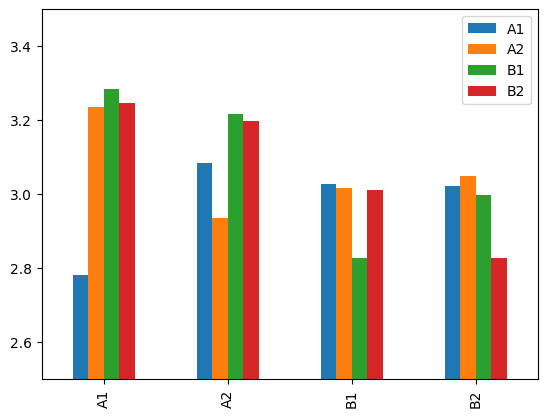

In [210]:
df.transpose().plot.bar(ylim=(2.5, 3.5))